# COMP24112 Summative Exercise: Air Quality Analysis (30 Marks)

This lab exercise is about air quality analysis, where you will predict air quality through solving classification and regression tasks. You will submit a notebook file, a pdf report, and a trained model. You will be marked for implementation, design, result and analysis. Your code should be easy to read and your report should be concise (max 600 words). It is strongly recommended that you use a LaTeX editor, such as [Overleaf](https://www.overleaf.com/), to write your report.

Please note your notebook should take no more than 10 minutes to run on lab computers. **There is 1 mark for code efficiency.**

## 1. Dataset and Knowledge Preparation

The provided dataset contains measurements of air quality from a multisensor device. The device used spectrometer analyzers (variables marked by "GT") and solid state metal oxide detectors (variables marked by "PT08.Sx"), as well as temperature (T), relative humidity (RH) and absolute humidity (AH) sensors. 

The dataset contains 3304 instances of hourly averaged measurements taken at road level in a polluted city. You will predict the CO(GT) variable representing carbon monoxide levels. There are missing features in this dataset, flagged by the number `-999`. 

You will need to pre-process the dataset to handle missing features, for which please self-learn from scikit-learn on how to [impute missing values](https://scikit-learn.org/stable/modules/impute.html). You will need to split the dataset into training and testing sets, also to run cross validation, when you see fit. For this, please self-learn from scikit-learn on [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).   

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()

# Import data - it should be saved in the same root directory as this notebook
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(10)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
3155,2.1,1082.75,10.680403,1002.75,95.0,787.25,112.0,1524.00,841.50,34.025001,19.225000,1.007275
2562,4.0,1319.00,17.669423,1229.75,494.0,550.50,109.0,1784.75,1380.75,20.825000,65.800000,1.600073
2273,3.2,1284.50,18.416284,1251.50,364.0,581.25,134.0,1866.00,1292.75,26.625000,44.325000,1.522861
1820,1.7,1117.75,10.563966,998.50,69.0,705.50,79.0,1766.00,878.25,34.700001,35.899999,1.952787
2880,0.7,836.25,2.857483,643.00,38.0,1244.25,49.0,1306.00,727.00,7.700000,70.725000,0.746322
707,2.2,1348.75,8.838885,933.00,152.0,933.00,119.0,1616.50,1348.75,14.725000,55.925000,0.931386
3124,3.4,1445.75,17.474183,1224.00,444.5,471.25,153.2,1705.75,1450.00,21.750000,47.375000,1.218420
41,3.4,1135.25,12.757143,1075.50,491.0,685.00,171.0,1119.75,1395.75,4.275000,49.400001,0.413830
941,2.0,1242.50,8.706317,927.75,109.0,851.75,100.0,1622.00,1078.75,17.500000,50.900000,1.008977
1579,1.1,918.00,5.298117,778.25,165.0,864.25,68.0,1136.00,859.00,7.525000,81.450001,0.849534


## 2. Linear Classification via Gradient Descent (13 marks)

The air quality is assessed using the CO(GT) variable. If it is no greater than 4.5, the air quality is good (CO(GT)<=4.5), otherwise, it is bad  (CO(GT)>4.5). You will perform binary classification to predict whether the air quality is good based on the other 11 varivables, i.e., from PT08.S1(CO) to AH. 

### 2.1 Model Training and Testing (4 marks)

This practice is about training a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation, and then testing its performance. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is 
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

Recall from your lectures that gradient descent is an iterative optimisation algorithm typically used in model training. Complete the implmentation of the training function `linear_gd_train` below, which trains your linear model by minimising the above provided training objective function $O$ using gradient descent.

The function should return the trained model weights and the corresponding objective function value (referred to as cost) per iteration. In addition to the training data, the function should take the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A default setting of these parameters has been provided below, which is able to provide reasonably good performance.  

**Note that scikit-learn is not allowed for implementation in this section.** We recommend that you avoid using `for` loops in your implementation of the objective function or weight update, and instead use built-in numpy operations for efficiency. 

In [2]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.001, random_state=None # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent

    Returns an array of cost and model weights per iteration.
    """
    # Number of features and data points
    n_samples, n_features = data.shape
    
    # Initialize weights (w) and bias (w0)
    w = np.random.randn(n_features)
    w0 = np.random.randn()

    # Adding bias term to data (X_tilde)
    X_tilde = np.c_[np.ones(n_samples), data]  # Adding a column of ones for the bias term

    # Initialize lists to store the cost and weights at each iteration
    cost_all = []
    w_all = []

    # Gradient Descent iterations
    for i in range(n_iters):
        # Calculate hinge loss
        margins = labels * (np.dot(X_tilde, np.append(w0, w)))
        losses = np.maximum(0, 1 - margins)

        # Calculate cost with L2 regularization
        cost = c * np.sum(losses) + 0.5 * np.dot(w, w)
        cost_all.append(cost)

        # Calculate gradients for w and w0
        indicator = (margins < 1).astype(int)  # Indicator function for hinge loss gradient
        dw = -c * np.dot(indicator * labels, data) + w  # Gradient for w with L2 regularization
        dw0 = -c * np.sum(indicator * labels)  # Gradient for w0 (bias term)

        # Update weights with gradient
        w -= learning_rate * dw
        w0 -= learning_rate * dw0

        # Save weights of this iteration
        w_all.append(np.append(w0, w))

    return np.array(cost_all), np.array(w_all)


def linear_predict(data, w):
    """
    A summary of your function goes here.

    data: test data
    w: model weights

    Returns the predicted labels.
    """

    # X_tilde = ...
    # y_pred = ...
    
    # return y_pred
    X_tilde = np.c_[np.ones(data.shape[0]), data]  # Adding a column of ones for the bias term

    # Compute raw predictions
    raw_pred = np.dot(X_tilde, w)

    # Convert to binary predictions (-1 or 1)
    y_pred = np.where(raw_pred >= 0, 1, -1)
    
    return y_pred


Now, you are ready to conduct a complete experiment of air quality classification. The provided code below splits the data into training and testing sets and imputes the missing features. 

In [3]:
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

Write your code below, which should train the model, plot the training objective function value and the classification accuracy of the training set over iterations, and print the classification accuracy and $F_1$ score of the testing set. Note, use the default setting provided for $C$, $\eta$ and $N_{max}$. Your plot should have axis labels and titles.

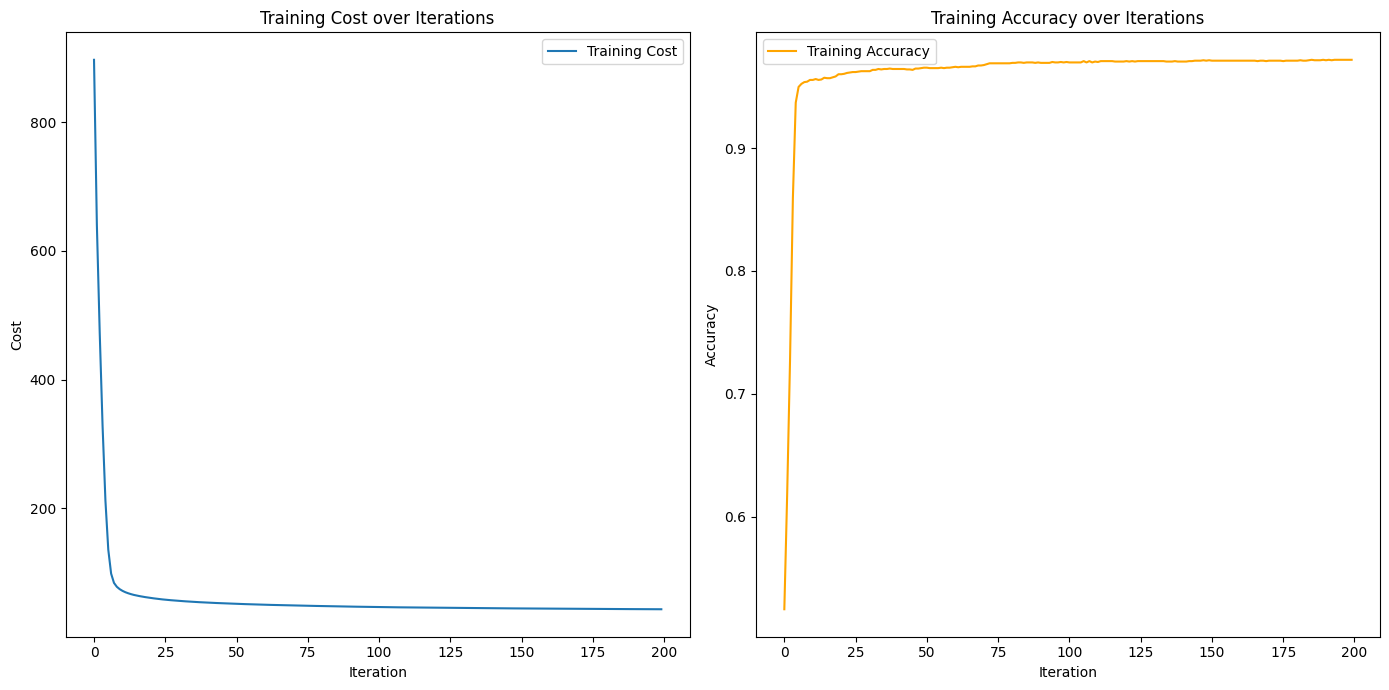

Test Accuracy: 0.9657
Test F1 Score: 0.7536


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)
test_X_cls = imputer.transform(test_X_cls)
test_X_cls = scaler.transform(test_X_cls)

# Convert binary targets to -1 and 1 for hinge loss
train_y_cls = np.where(train_y_cls == 0, -1, 1)
test_y_cls = np.where(test_y_cls == 0, -1, 1)

# Train the model using the linear_gd_train function defined earlier
cost_history, weight_history = linear_gd_train(train_X_cls, train_y_cls, c=0.2, n_iters=200, learning_rate=0.001, random_state=42)

def calculate_f1_score(y_true, y_pred):
    # True positives are the correctly predicted positive values
    tp = sum((y_true == 1) & (y_pred == 1))

    # Predicted positives
    pp = sum(y_pred == 1)

    # Actual positives
    ap = sum(y_true == 1)

    # Precision is the ratio of correctly predicted positive observations to the total predicted positives
    precision = tp / pp if pp else 0

    # Recall is the ratio of correctly predicted positive observations to the all observations in actual class
    recall = tp / ap if ap else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    
    return f1_score

def calculate_accuracy(y_true, y_pred):
    """
    Calculate the accuracy of predictions.

    y_true: numpy.ndarray, true labels
    y_pred: numpy.ndarray, predicted labels

    Returns the accuracy score.
    """
    correct_predictions = np.sum(y_true == y_pred)
    accuracy = correct_predictions / y_true.shape[0]
    return accuracy

# Plot training cost and accuracy over iterations
plt.figure(figsize=(14, 7))

# Plot training cost
plt.subplot(1, 2, 1)
plt.plot(cost_history, label='Training Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Training Cost over Iterations')
plt.legend()

# Since the training accuracy is not directly computed in the training function,
# we need to calculate the accuracy at each iteration using the weights history.
train_accuracies = [calculate_accuracy(train_y_cls, linear_predict(train_X_cls, w)) for w in weight_history]

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Iterations')
plt.legend()

plt.tight_layout()
plt.show()

# Predict on the test set and evaluate
test_predictions = linear_predict(test_X_cls, weight_history[-1])
test_accuracy = calculate_accuracy(test_y_cls, test_predictions)
test_f1_score = calculate_f1_score(test_y_cls, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1_score:.4f}')



### 2.2 Learning Rate Analysis (3 marks)

The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. Design an appropriate experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

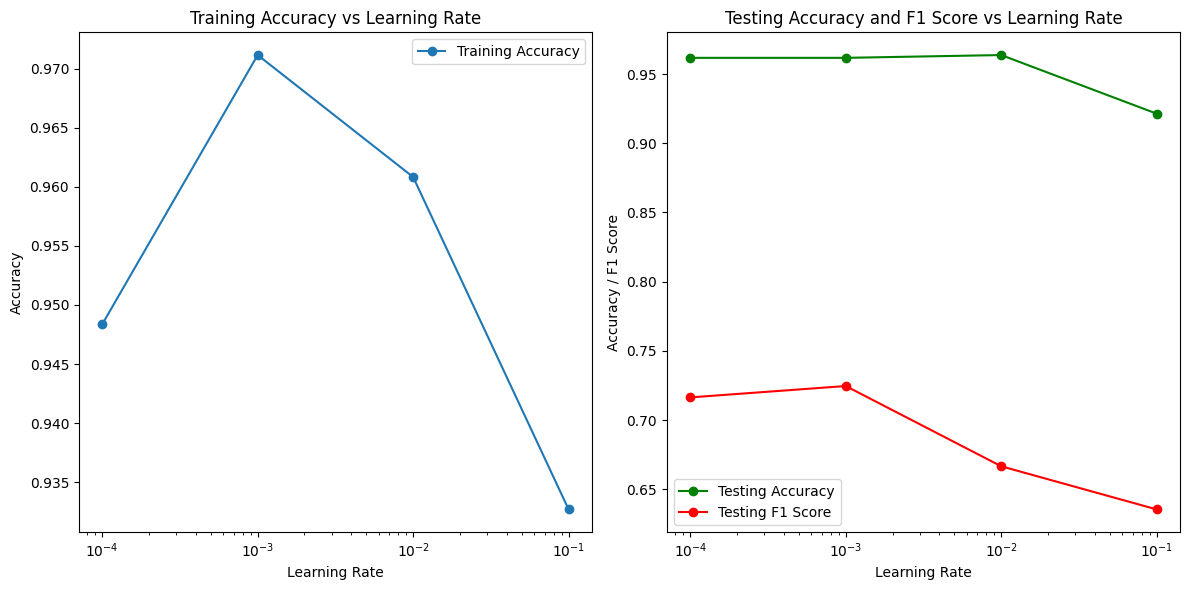

Learning Rate: 0.0001
Training Accuracy: 0.9484
Testing Accuracy: 0.9617
Testing F1 Score: 0.7164
----------
Learning Rate: 0.001
Training Accuracy: 0.9712
Testing Accuracy: 0.9617
Testing F1 Score: 0.7246
----------
Learning Rate: 0.01
Training Accuracy: 0.9608
Testing Accuracy: 0.9637
Testing F1 Score: 0.6667
----------
Learning Rate: 0.1
Training Accuracy: 0.9327
Testing Accuracy: 0.9214
Testing F1 Score: 0.6355
----------


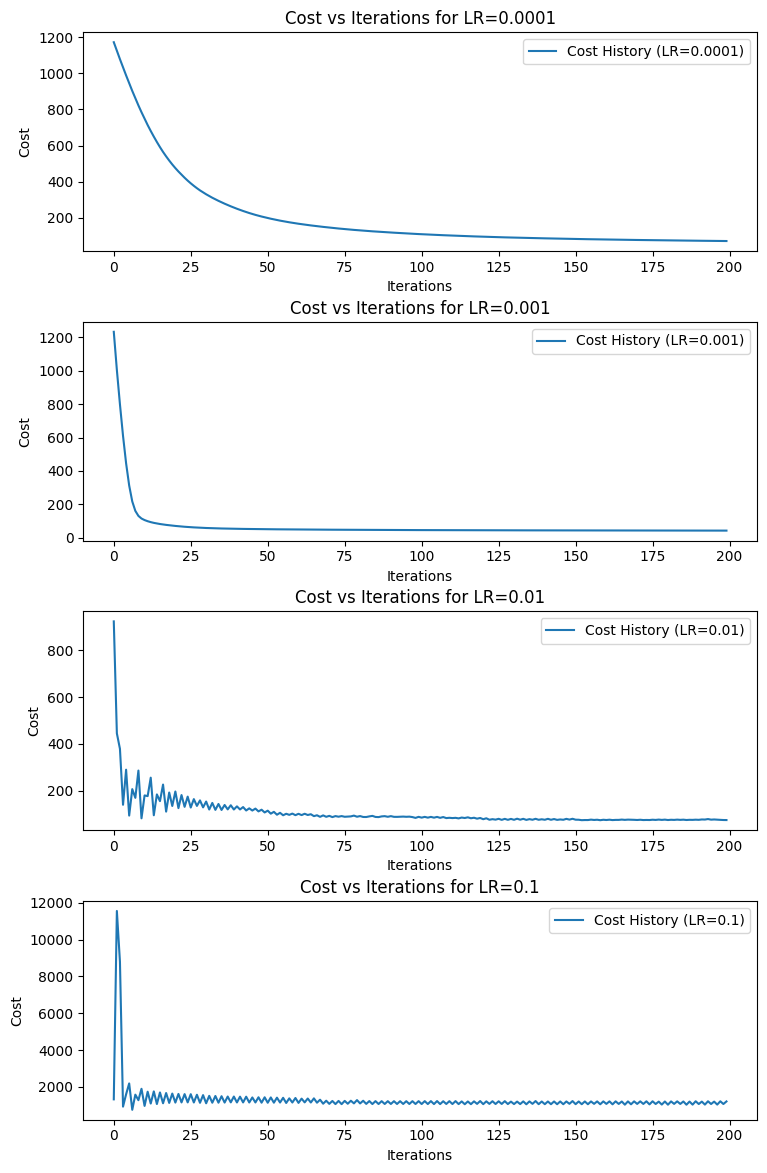

In [5]:
import matplotlib.pyplot as plt

learning_rates = [0.0001, 0.001, 0.01, 0.1]

training_accuracies = []
test_accuracies = []
test_f1_scores = []
cost_histories = []

# Run training for each learning rate and record the accuracies and costs
for lr in learning_rates:
    cost_history, weight_history = linear_gd_train(train_X_cls, train_y_cls, c=0.2, n_iters=200, learning_rate=lr, random_state=42)
    final_weights = weight_history[-1]
    train_predictions = linear_predict(train_X_cls, final_weights)
    test_predictions = linear_predict(test_X_cls, final_weights)

    # Calculate accuracies and f1 scores
    train_accuracy = calculate_accuracy(train_y_cls, train_predictions)
    test_accuracy = calculate_accuracy(test_y_cls, test_predictions)
    test_f1 = calculate_f1_score(test_y_cls, test_predictions)

    # Append to our lists
    training_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    test_f1_scores.append(test_f1)
    cost_histories.append(cost_history)

# Plot the accuracies and F1 scores for each learning rate
plt.figure(figsize=(12, 6))

# Training accuracies
plt.subplot(1, 2, 1)
plt.plot(learning_rates, training_accuracies, 'o-', label='Training Accuracy')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Learning Rate')
plt.legend()

# Testing accuracies and F1 scores
plt.subplot(1, 2, 2)
plt.plot(learning_rates, test_accuracies, 'o-', color='green', label='Testing Accuracy')
plt.plot(learning_rates, test_f1_scores, 'o-', color='red', label='Testing F1 Score')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy / F1 Score')
plt.title('Testing Accuracy and F1 Score vs Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the cost vs iterations for each learning rate
fig, axes = plt.subplots(len(learning_rates), 1, figsize=(8, 12))
fig.tight_layout(pad=3.0)

for i, lr in enumerate(learning_rates):
    ax = axes[i]
    ax.plot(cost_histories[i], label=f'Cost History (LR={lr})')
    ax.set_title(f'Cost vs Iterations for LR={lr}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.legend()
for i, lr in enumerate(learning_rates):
    print(f"Learning Rate: {lr}")
    print(f"Training Accuracy: {training_accuracies[i]:.4f}")
    print(f"Testing Accuracy: {test_accuracies[i]:.4f}")
    print(f"Testing F1 Score: {test_f1_scores[i]:.4f}")
    print("----------")
# Print the accuracies and F1 scores for quick reference




### 2.3 Report (6 Marks)
Answer the following questions in your report, to be submitted separately:
1. Derive step-by-step the gradient of the provided training objective function $O$, and the updating equation of your model weights based on gradient descent. (3 marks)

2. What does the figure from section 2.1 tell you, and what is the indication of the classification accuracies of your training and testing sets? (1 mark)

3. Comment on the effect of $\eta$ on model training, and on the model performance during testing, based on your results observed in Section 2.2. (2 marks)

## 3. Air Quality Analysis by Neural Network (10 marks)

In this experiment, you will predict the CO(GT) value based on the other 11 variables through regression. You will use a neural network to build a nonlinear regression model. Familiarise yourself with how to build a regression model by mutlilayer perceptron (MLP) using the scikit learn tutorial (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression). 


### 3.1 Simple MLP Model Selection (4 marks)

This section is focused on the practical aspects of MLP implementation and model selection. We will first compare some model architectures. 

The set of MLP architectures to select is specified in `param_grid` below, including two MLPs with one hidden layer, where one has a small number of 3 hidden neurons, while the other has a larger number of 100 hidden neurons, and two MLPs with two hidden layers, where one is small (3, 3) and the other is larger (100, 100). It also includes two activation function options, i.e., the logistic and the rectified linear unit ("relu").  These result in a total of 8 model options, where sklearn default parameters are used for all the MLPs and their training. 

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {   
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

Your code below should do the following: Split the dataset into the training and testing sets. Preprocess the data by imputing the missing features. Use the training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. You can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation of the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.  


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Load data
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
sensor_data_imputed = imputer.fit_transform(sensor_data_full)

# Extract features and target variable
X = sensor_data_imputed[:, 1:]  # Assuming the first column is CO(GT), which we want to predict
y = sensor_data_imputed[:, 0]  # CO(GT)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
    'activation': ['relu', 'logistic'],
}

# Initialize the MLPRegressor
mlp = MLPRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_mlp = grid_search.best_estimator_

# Print the best parameters and the corresponding MSE from CV
best_parameters = grid_search.best_params_
best_cv_score = -grid_search.best_score_
print(f"Best parameters: {best_parameters}")
print(f"Cross-validated MSE: {best_cv_score}")

# Re-train the selected model using the whole training set
best_mlp.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = best_mlp.predict(X_test_scaled)

# Calculate MSE and R-squared for the testing set
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

# Print the MSE and R^2 score for the testing set
print(f"Test MSE: {test_mse}")
print(f"Test R^2 Score: {test_r2}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100)}
Cross-validated MSE: 0.17850583012137564
Test MSE: 0.19144067427429307
Test R^2 Score: 0.9103077399823362


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 3.2 Training Algorithm Comparison: SGD and ADAM (2 Marks)

In this exercise, you will compare two training algorithms, stochastic gradient descent (SGD) and ADAM optimisation, for training an MLP with two hidden layers each containing 100 neurons with "relu" activation, under the settings specified in `test_params` as below.

In [8]:
test_params = [
    {
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'solver': 'adam'
    },{
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'learning_rate': 'adaptive', 
        'momentum': 0.95, 
        'solver': 'sgd'
    },
]

Write the code below, where each training algorithm should run for 300 iterations (make sure to set `early_stopping=False`). For both algorithms, (1) plot the training loss (use the defaul loss setting in sklearn), as well as the MSE of both training and testing sets, over iterations; and (2) print the MSE and $R^2$ score of the trained model using the testing set. 

Model 300 (ADAM) Test MSE: 0.23672105188677356
Model 300 (ADAM) Test R^2 Score: 0.8890933380904078
---
Model 300 (SGD) Test MSE: 0.19927153839917097
Model 300 (SGD) Test R^2 Score: 0.9066388858899963
---


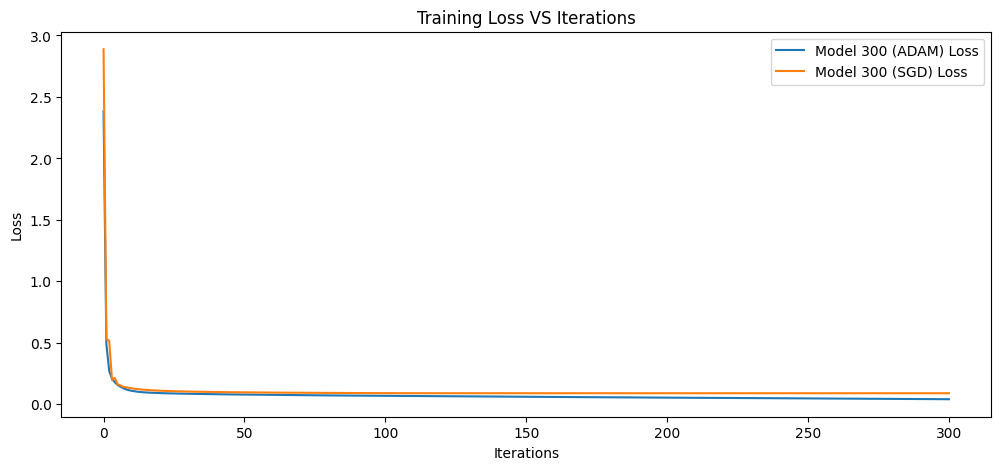

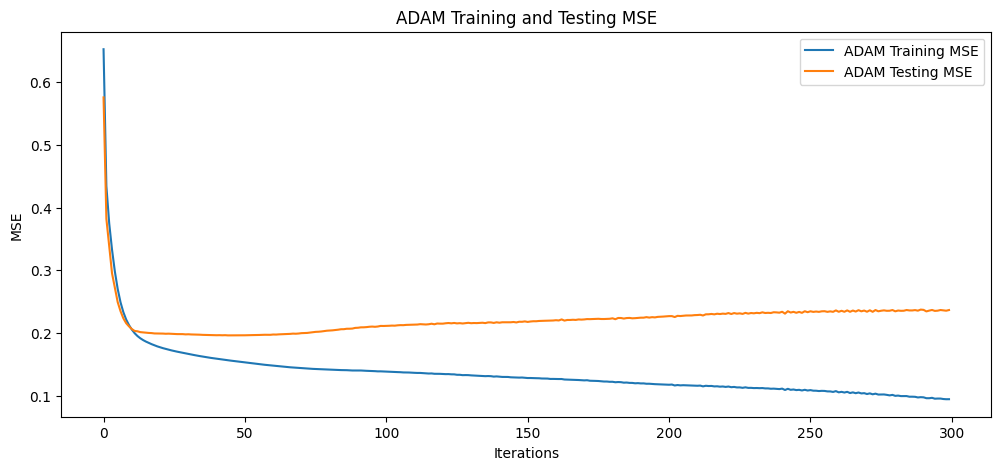

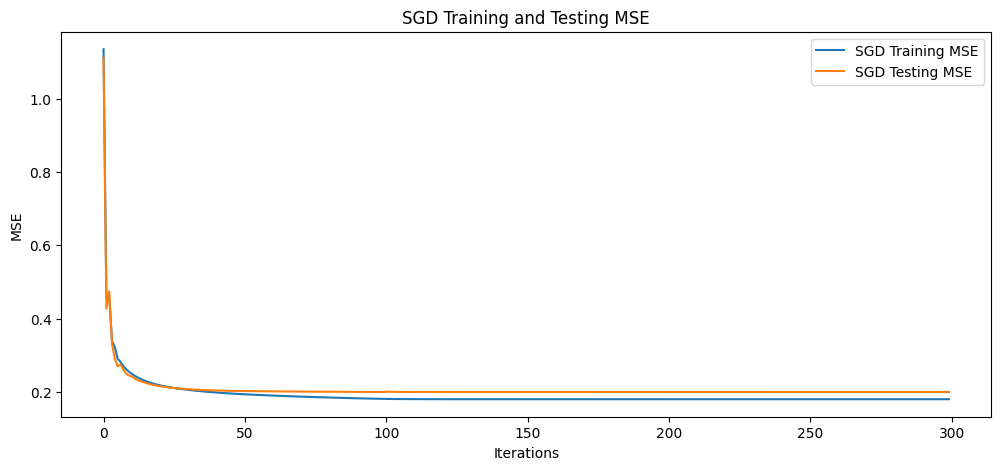

In [9]:
# Train models and plot learning curves


# Print final test set performance for both models
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming the data is already preprocessed and split into train_X, test_X, train_y, test_y
# If the data is not split, we need to preprocess and split as done before.

# Define the two sets of parameters for comparison
test_params = [
    {
        'activation': 'relu',
        'alpha': 0.001,
        'early_stopping': False,
        'hidden_layer_sizes': (100, 100),
        'solver': 'adam',
        # 'max_iter': 300,
        'random_state': 42
    },
    {
        'activation': 'relu',
        'alpha': 0.001,
        'early_stopping': False,
        'hidden_layer_sizes': (100, 100),
        'solver': 'sgd',
        'learning_rate': 'adaptive',
        'momentum': 0.95,
        # 'max_iter': 300,
        'random_state': 42
    }
]

adam_train_mse=[]
adam_test_mse=[]
sgd_train_mse=[]
sgd_test_mse=[]
plt.figure(figsize=(12, 5))

for i, params in enumerate(test_params):
    mlp = MLPRegressor(**params)
    mlp.partial_fit(X_train_scaled, y_train)
    
    for i in range(300):
        mlp.partial_fit(X_train_scaled, y_train)
        train_predictions = mlp.predict(X_train_scaled)
        test_predictions = mlp.predict(X_test_scaled)
        train_mse = mean_squared_error(y_train, train_predictions)
        test_mse = mean_squared_error(y_test, test_predictions)
    
        # Store MSE values in the corresponding lists
        if params['solver'] == 'adam':
            adam_train_mse.append(train_mse)
            adam_test_mse.append(test_mse)
        else:
            sgd_train_mse.append(train_mse)
            sgd_test_mse.append(test_mse)

    # Plot the training loss
    plt.plot(mlp.loss_curve_, label=f'Model {i+1} ({params["solver"].upper()}) Loss')

    # Print final test set performance for both models
    predictions = mlp.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Model {i+1} ({params['solver'].upper()}) Test MSE: {mse}")
    print(f"Model {i+1} ({params['solver'].upper()}) Test R^2 Score: {r2}")
    print("---")

plt.title('Training Loss VS Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(12, 5))
plt.plot(adam_train_mse, label='ADAM Training MSE')
plt.plot(adam_test_mse, label='ADAM Testing MSE')
plt.title('ADAM Training and Testing MSE')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

plt.show()

# Plotting MSE curves for SGD
plt.figure(figsize=(12, 5))

plt.plot(sgd_train_mse, label='SGD Training MSE')
plt.plot(sgd_test_mse, label='SGD Testing MSE')
plt.title('SGD Training and Testing MSE')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

plt.show()

### 3.3 Report (4 Marks)
Answer the following questions in your report, to be submitted separately:
1. What conclusions can you draw based on your model selection results in Section 3.1? (2 marks)

2. Comment on the two training algorithms based on your results obtained in Section 3.2. (2 marks)

## 4.  Build A Robust MLP Regressor (6 Marks)

In this last experiment, you will develop and submit a robust MLP regressor to predict the CO(GT) value based on the other 11 variables, using the provided dataset. This robust regressor should account for the presence of missing and noisy features. 

Once you have developed your model, save it to a file using the provided `save_model` function for submission.

### 4.1 Model Development (3 Marks)

What you consider in model development should include (but not limited to) (1) handling of missing features in the unseen testing data, (2) handling of noisy features in the unseen testing data, and (3) a model selection practice.

Write your model development code below. Describe briefly in your report what you have considered in your model development.


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from joblib import dump

# Load data
try:
    sensor_data_full = pd.read_excel('sensor_data.xlsx')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The file was not found.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit()

# Check for required column in the dataset
if 'CO(GT)' not in sensor_data_full.columns:
    print("Error: Dataset must include 'CO(GT)' column.")
    exit()

# Check for any NaN or infinite values in the dataset
if sensor_data_full.isnull().any().any() or np.isinf(sensor_data_full.values).any():
    print("Error: Data contains NaN or infinite values.")
    exit()

# Split data into features and target
X = sensor_data_full.drop(columns=['CO(GT)'])
y = sensor_data_full['CO(GT)'].values

# Create a preprocessing pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # More robust than mean
    ('scaler', RobustScaler()),  # Less sensitive to outliers
    ('filter', VarianceThreshold())  # Removes low-variance features
])

# Apply preprocessing to the data
try:
    X_processed = pipeline.fit_transform(X)
    print("Preprocessing completed successfully.")
except Exception as e:
    print(f"An error occurred during preprocessing: {e}")
    exit()

# Define parameters for the grid search
param_grid = {
    'hidden_layer_sizes': [(100, 50), (50, 25)],
    'activation': ['relu'],
    'alpha': [0.001, 0.0001],
    'learning_rate_init': [0.001, 0.01]
}

# Setup MLPRegressor with a grid search
mlp = MLPRegressor(max_iter=1000, random_state=42)
grid_search = GridSearchCV(mlp, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Perform grid search to find the best parameters
try:
    grid_search.fit(X_processed, y)
    print("Grid search completed successfully.")
except Exception as e:
    print(f"An error occurred during model training: {e}")
    exit()

# Get the best estimator
best_mlp = grid_search.best_estimator_

# Save the best model to a file
try:
    dump(best_mlp, 'best_mlp_regressor.joblib')
    print("Model saved successfully.")
except Exception as e:
    print(f"An error occurred when saving the model: {e}")
    exit()

# Evaluate the model on the test set
y_pred_train= best_mlp.predict(X_processed)
train_mse = mean_squared_error(y, y_pred_train)
train_r2 = r2_score(y, y_pred_train)

print(f"Test MSE: {train_mse}")
print(f"Test R^2 Score: {train_r2}")


Data loaded successfully.
Preprocessing completed successfully.
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid search completed successfully.
Model saved successfully.
Test MSE: 0.13375454576690957
Test R^2 Score: 0.9321460216104787


## 4.2 External Testing (3 Marks)
Save your trained model for submission, and submit it along with your notebook and report. It will be run and evaluated on a test set unseen by you.

**Important: set your university username (e.g. mbxxabc3) below when saving your model.** Failure to do this correctly would lead to your model not being marked!

In [11]:
import model_eval_utils

#### SAVE YOUR MODEL
username = "g49678gs"
model = best_mlp # SET YOUR MODEL HERE
model_eval_utils.save_model(username, model)

In [12]:
print(f"Total notebook run time: {time.time() - notebook_start_time:.0f} seconds")

Total notebook run time: 205 seconds


### Option to test your saved model
Use the `run_model()` function to make sure your saved model can be loaded and run before submitting.

Please note the score returned by `run_model()` is not in any way indicative of your final mark. This is just a simple test to make sure your model can be loaded and run. When testing your model, the GTA will run your model following the practice below, but replacing the bunk_data with the testing data.

In [13]:
# some bunk data
bunk_data = np.array([[ 1.22400000e+03,  9.97440117e+00,
        9.76666667e+02,  2.50600000e+02,  5.71333333e+02,
        1.30700000e+02,  1.42433333e+03,  1.00166667e+03,
        2.32666664e+01,  3.57999992e+01,  1.00855762e+00],
    [ 9.24250000e+02,   3.97337806e+00,
        7.09250000e+02,  6.30000000e+01,  1.15800000e+03,
        7.50000000e+01,  1.31800000e+03,  6.09750000e+02,
        1.60500000e+01,  4.13500004e+01,  7.48680717e-01],
    [ 8.92000000e+02,  5.06611560e+00,
        7.66750000e+02,  7.10000000e+01,  1.18000000e+03,
        8.40000000e+01,  1.46600000e+03,  6.56750000e+02,
        1.79749999e+01,  5.14499998e+01,  1.05039283e+00]])
bunk_labels = np.array([2. , 1.3, 6.1])

score = model_eval_utils.run_model(username, 
                                test_data=bunk_data, 
                                test_labels=bunk_labels, 
                                model_folder=".")

Attempting to load from ....
Loaded .\g49678gs.sav model.
Model score: -765304.9959365312
